 ## Keras Model to Lucid Model Pipeline



The not yet publsihed lucid version 0.3.9 needs to be installed directly from github. 
Older version do not have the Model.save function.


In [2]:
# Install Lucid

#!pip install --quiet lucid==0.3.8
# install from github to get version 0.3.9
!pip install git+https://github.com/tensorflow/lucid.git
 
# %tensorflow_version only works on colab
%tensorflow_version 1.x


  Cloning https://github.com/tensorflow/lucid.git to /tmp/pip-req-build-e_nq1_3s
  Running command git clone -q https://github.com/tensorflow/lucid.git /tmp/pip-req-build-e_nq1_3s
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=158767 sha256=ddece46ef12e1cc1e9cf4434727c8699374491b3d9e2ba9bb84f7c4a5a61a1bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-no77rzkg/wheels/64/c2/51/7238e75f457453774587708b21cd3cf32f9a86456648688634
Successfully built lucid
  Found existing installation: lucid 0.3.8
    Uninstalling lucid-0.3.8:
      Successfully uninstalled lucid-0.3.8


In [ ]:

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')
import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
import lucid
from lucid.modelzoo.vision_models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# load tf.keras model
mobile_v2 = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


14540800/14536120 [==============================] - 1s 0us/step


In [ ]:
# save model as h5 file
path = r'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models/mobile_v2.h5'
mobile_v2.save(path, save_format = 'h5')

In [ ]:
 def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [ ]:
from keras import backend as K

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Using TensorFlow backend.


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 524 variables.


INFO:tensorflow:Froze 524 variables.


INFO:tensorflow:Converted 524 variables to const ops.


INFO:tensorflow:Converted 524 variables to const ops.


In [ ]:
# create pb file
tf.train.write_graph(frozen_graph, "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models", "my_model.pb", as_text=False)


'/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models/my_model.pb'

In [ ]:
from tensorflow.python.platform import gfile
from lucid.modelzoo.vision_models import Model

GRAPH_PB_PATH = '/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models/my_model.pb'
with tf.Session() as sess, tf.Graph().as_default() as graph:
    #images = tf.placeholder("float32", [None, 224, 224, 3], name="input")

    print("load graph")
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
       names.append(t.name)
    print(names)
    Model.suggest_save_args()
    Model.save(
        "/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models/mobile_lucid.pb",  # Local paths are also fine!
        input_name   = 'input_3',
        output_names = ['Logits_1/Softmax'] ,
        image_shape  = [224, 224, 3],
        image_value_range = [-1,1]
  )

load graph
['Conv1/kernel', 'bn_Conv1/gamma', 'bn_Conv1/beta', 'bn_Conv1/moving_mean', 'bn_Conv1/moving_variance', 'keras_learning_phase/input', 'keras_learning_phase', 'expanded_conv_depthwise/depthwise_kernel', 'expanded_conv_depthwise_BN/gamma', 'expanded_conv_depthwise_BN/beta', 'expanded_conv_depthwise_BN/moving_mean', 'expanded_conv_depthwise_BN/moving_variance', 'expanded_conv_project/kernel', 'expanded_conv_project_BN/gamma', 'expanded_conv_project_BN/beta', 'expanded_conv_project_BN/moving_mean', 'expanded_conv_project_BN/moving_variance', 'block_1_expand/kernel', 'block_1_expand_BN/gamma', 'block_1_expand_BN/beta', 'block_1_expand_BN/moving_mean', 'block_1_expand_BN/moving_variance', 'block_1_depthwise/depthwise_kernel', 'block_1_depthwise_BN/gamma', 'block_1_depthwise_BN/beta', 'block_1_depthwise_BN/moving_mean', 'block_1_depthwise_BN/moving_variance', 'block_1_project/kernel', 'block_1_project_BN/gamma', 'block_1_project_BN/beta', 'block_1_project_BN/moving_mean', 'block_1_

INFO:tensorflow:Froze 0 variables.


INFO:tensorflow:Converted 0 variables to const ops.


INFO:tensorflow:Converted 0 variables to const ops.


In [ ]:
model = Model.load("/content/drive/My Drive/Colab Notebooks/Bachelor Arbeit/Models/mobile_lucid.pb")


In [ ]:

for name in names:
    print(name)
    print("")

Conv1/kernel

bn_Conv1/gamma

bn_Conv1/beta

bn_Conv1/moving_mean

bn_Conv1/moving_variance

keras_learning_phase/input

keras_learning_phase

expanded_conv_depthwise/depthwise_kernel

expanded_conv_depthwise_BN/gamma

expanded_conv_depthwise_BN/beta

expanded_conv_depthwise_BN/moving_mean

expanded_conv_depthwise_BN/moving_variance

expanded_conv_project/kernel

expanded_conv_project_BN/gamma

expanded_conv_project_BN/beta

expanded_conv_project_BN/moving_mean

expanded_conv_project_BN/moving_variance

block_1_expand/kernel

block_1_expand_BN/gamma

block_1_expand_BN/beta

block_1_expand_BN/moving_mean

block_1_expand_BN/moving_variance

block_1_depthwise/depthwise_kernel

block_1_depthwise_BN/gamma

block_1_depthwise_BN/beta

block_1_depthwise_BN/moving_mean

block_1_depthwise_BN/moving_variance

block_1_project/kernel

block_1_project_BN/gamma

block_1_project_BN/beta

block_1_project_BN/moving_mean

block_1_project_BN/moving_variance

block_2_expand/kernel

block_2_expand_BN/gamma


512 22.8064



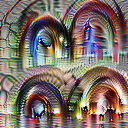

In [ ]:

img = render.render_vis(model, "block_11_add_1/add:32")
